# Домашнее задание №3. Dataset, Dataloader, BatchNorm, Dropout, Оптимизация

In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 4.5 MB/s 


In [3]:
# загрузка датасета
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np

# разделение датасета
from sklearn.model_selection import train_test_split

# преобразование данных
from sklearn.preprocessing import MinMaxScaler
from torchvision import transforms

#построение модели
import torch
import torch.nn as nn
import torch.nn.functional as F

# метрика
import torchmetrics

#отрисовка графиков
from matplotlib import pyplot as plt 

## Задание

1. Создать Dataset для загрузки данных (sklearn.datasets.fetch_california_housing, train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25)

2. Обернуть его в Dataloader

3. Написать архитектуру сети, которая предсказывает стоимость недвижимости. Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)

4. Сравнить сходимость Adam, RMSProp и SGD, сделать вывод по качеству работы модели

## 0. Загрузка данных<a id='section_0'></a>

In [4]:
housing = fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=False, as_frame=True)
df = housing['frame']
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [5]:
# пропусков в данных нет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [6]:
# целевая переменная
target = housing['target_names'][0]
target

'MedHouseVal'

In [7]:
# список признаков
features_list = housing['feature_names']
features_list

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [8]:
# собираем признаки и целевую переменную
X = df[features_list]
y = df[target]

In [9]:
# разделяем датасет на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)
print(f'Тренировочный набор: {X_train.shape}, {y_train.shape}')
print(f'Тестовый набор: {X_test.shape}, {y_test.shape}')

Тренировочный набор: (15480, 8), (15480,)
Тестовый набор: (5160, 8), (5160,)


In [10]:
#стандартизация данных
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train).float()
y_train = torch.FloatTensor(y_train.values).float()

X_test = torch.FloatTensor(X_test).float()
y_test = torch.FloatTensor(y_test.values).float()

## 1. Dataset и Dataloader <a id='section_1'></a>

In [11]:
# класс датасета
class MyOwnClass(torch.utils.data.Dataset):
   
    def __init__(self, X_data, y_data):
        self._X = X_data
        self._y = y_data

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        X = self._X[idx] 
        y = self._y[idx] 
       
        return X, y

In [12]:
# создание представителя тренировочного датасета и его dataloader
train_dataset = MyOwnClass(X_train, y_train)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

In [13]:
# элементы тренировочного датасета
train_dataset[0], train_dataset[0][0].shape, train_dataset[0][1].shape 

((tensor([0.2081, 0.6863, 0.0243, 0.0226, 0.0379, 0.0011, 0.1775, 0.6096]),
  tensor(2.6800)),
 torch.Size([8]),
 torch.Size([]))

In [14]:
# элементы тренировочного даталоадера
for idx, batch in enumerate(train_loader):
    print(idx, 'Tensor: ', batch[0], batch[0].shape)  # 128 батчей с 8 признаками
    print(idx, 'target: ', batch[1], batch[1].shape)  # 128 значений target
    break

0 Tensor:  tensor([[0.5192, 0.1961, 0.0488,  ..., 0.0023, 0.1467, 0.6474],
        [0.1843, 0.3137, 0.0383,  ..., 0.0017, 0.5813, 0.2550],
        [0.1191, 0.5882, 0.0273,  ..., 0.0023, 0.3889, 0.4980],
        ...,
        [0.2869, 0.0588, 0.0276,  ..., 0.0011, 0.1031, 0.6633],
        [0.1740, 0.1176, 0.0428,  ..., 0.0016, 0.5090, 0.4711],
        [0.1468, 0.6078, 0.0245,  ..., 0.0024, 0.1690, 0.6424]]) torch.Size([128, 8])
0 target:  tensor([3.7180, 1.4680, 0.5080, 0.9380, 1.9810, 1.4010, 1.7370, 0.4750, 1.6830,
        2.5460, 1.8360, 2.0580, 1.4140, 1.9380, 3.4280, 3.0580, 3.2850, 1.2080,
        1.2710, 1.3350, 1.3300, 5.0000, 2.3040, 3.2400, 2.8080, 1.8210, 0.7590,
        5.0000, 2.0420, 1.6200, 0.6410, 1.7360, 3.3820, 1.1430, 0.7890, 1.4610,
        0.9410, 1.9130, 0.9380, 1.1150, 1.2490, 1.8330, 3.8250, 2.2940, 4.1250,
        4.0000, 2.1750, 2.9420, 2.0700, 1.8930, 2.0330, 5.0000, 1.3650, 2.7860,
        2.1430, 0.6810, 3.1200, 5.0000, 0.9810, 5.0000, 2.2000, 2.3800, 1.5000,

In [15]:
# создание представителя тестового датасета и его dataloader
test_dataset = MyOwnClass(X_test, y_test)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=8,
                                          shuffle=False,
                                          drop_last=True,
                                          num_workers=0)

## 2. Построение нейронной сети <a id='section_2'></a>

In [16]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            return F.relu(x)
        raise RuntimeError
        
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 2*hidden_dim)
        self.dp1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(2*hidden_dim)
        self.fc2 = Perceptron(2*hidden_dim, hidden_dim)
        self.dp2 = nn.Dropout(0.2)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = Perceptron(hidden_dim, 1)
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn3(x)
        x = self.fc3(x)
        return x

In [17]:
# инициализация модели
net = FeedForward(8, 400)

# компиляция модели
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [18]:
num_epochs = 10

train_r2 = torchmetrics.R2Score()
test_r2 = torchmetrics.R2Score()

net.train()

for epoch in range(num_epochs):  
    
    running_loss, running_items = 0.0, 0.0
    
    for i, data in enumerate(train_loader):
        inputs, target = data[0], data[1]
        
        optimizer.zero_grad()
        outputs = net(inputs)
        train_r2(outputs.squeeze(), target)
        loss = criterion(outputs.squeeze(), target)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(target)
  
        # выводим статистику о процессе обучения
        if i % 60 == 0:    # печатаем каждые 60 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}, ', \
                  f'r2_train: {train_r2.compute().item():.3f}, ', end = ' ')
            running_loss, running_items = 0.0, 0.0
            train_r2.reset()

            for i, data in enumerate(test_loader):
                test_outputs = net(data[0])
                test_r2(test_outputs.squeeze(), data[1])
            
            print(f'r2_val: {test_r2.compute():.3f}')
            test_r2.reset()
            net.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/120]. Loss: 5.740,  r2_train: -2.914,  r2_val: -3.042
Epoch [1/10]. Step [61/120]. Loss: 1.339,  r2_train: -0.008,  r2_val: 0.392
Epoch [2/10]. Step [1/120]. Loss: 0.748,  r2_train: 0.352,  r2_val: 0.490
Epoch [2/10]. Step [61/120]. Loss: 0.694,  r2_train: 0.466,  r2_val: 0.542
Epoch [3/10]. Step [1/120]. Loss: 0.415,  r2_train: 0.544,  r2_val: 0.606
Epoch [3/10]. Step [61/120]. Loss: 0.594,  r2_train: 0.549,  r2_val: 0.600
Epoch [4/10]. Step [1/120]. Loss: 0.628,  r2_train: 0.616,  r2_val: 0.647
Epoch [4/10]. Step [61/120]. Loss: 0.506,  r2_train: 0.620,  r2_val: 0.636
Epoch [5/10]. Step [1/120]. Loss: 0.414,  r2_train: 0.647,  r2_val: 0.666
Epoch [5/10]. Step [61/120]. Loss: 0.471,  r2_train: 0.647,  r2_val: 0.675
Epoch [6/10]. Step [1/120]. Loss: 0.438,  r2_train: 0.652,  r2_val: 0.694
Epoch [6/10]. Step [61/120]. Loss: 0.438,  r2_train: 0.667,  r2_val: 0.705
Epoch [7/10]. Step [1/120]. Loss: 0.404,  r2_train: 0.659,  r2_val: 0.679
Epoch [7/10]. Step [61/120]. 

## 3. Модели нейронной сети с разными оптимизаторами <a id='section_3'></a>

In [19]:
def train_eval_model(model, optimizer, num_epochs):    
    
    train_r2 = torchmetrics.R2Score()
    test_r2 = torchmetrics.R2Score()
    
    r2_train_list = []
    r2_test_list = []
    
    for epoch in range(num_epochs):
        
        model.train()
        for i, data in enumerate(train_loader):
            inputs, target = data[0], data[1] # входные данные с лейблами
            # Обнуляем градиент
            optimizer.zero_grad()
            # Делаем предсказание
            outputs = model(inputs)
            #метрика
            batch_r2 = train_r2(outputs.squeeze(), target)
            # Рассчитываем лосс-функцию (функцию потерь)
            loss = criterion(outputs.squeeze(), target)
            # Вычисляем градиент
            loss.backward()
            # Обновляем веса (делаем шаг оптимайзера)
            optimizer.step()
        
        model.eval()
        for i, data in enumerate(test_loader):
            inputs, target = data[0], data[1]
            outputs = model(inputs)
            test_r2(outputs.squeeze(), target)

        # total r2 over all training batches
        total_train_r2 = train_r2.compute()
        # total r2 over all training batches
        total_test_r2 = test_r2.compute()
        
        r2_train_list.append(total_train_r2)
        r2_test_list.append(total_test_r2)
        print(f'Epoch {epoch+1}: r2_train = {total_train_r2}, r2_val = {total_test_r2}')

        #reset for next epoch
        train_r2.reset()
        test_r2.reset()
    
    return r2_train_list, r2_test_list

In [20]:
# функция визуализации метрик
def visual_metrics(r2_train_list, r2_test_list, optim):
    x = np.arange(1,11,1)
    y = r2_train_list
    y2 = r2_test_list

    plt.plot(x,y,label='R2_train')
    plt.plot(x,y2,label='R2_test')

    plt.title(f"NN with optim {optim}")   
    plt.ylabel('R2_score')   
    plt.xlabel('epochs')   
    plt.legend()
    plt.show()

In [21]:
torch.manual_seed(10)

#### Оптимизатор SGD

In [22]:
model = FeedForward(8, 400)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum =0.0)
r2_train_list_SGD, r2_test_list_SGD = train_eval_model(model, optimizer, 10)

Epoch 1: r2_train = 0.017322838306427002, r2_val = 0.45028018951416016
Epoch 2: r2_train = 0.3981422781944275, r2_val = 0.49966007471084595
Epoch 3: r2_train = 0.48378825187683105, r2_val = 0.5801625847816467
Epoch 4: r2_train = 0.5234606266021729, r2_val = 0.5911783576011658
Epoch 5: r2_train = 0.5569790005683899, r2_val = 0.5861023664474487
Epoch 6: r2_train = 0.5796942710876465, r2_val = 0.5690022706985474
Epoch 7: r2_train = 0.6183960437774658, r2_val = 0.632051944732666
Epoch 8: r2_train = 0.6470893621444702, r2_val = 0.6853400468826294
Epoch 9: r2_train = 0.6541188359260559, r2_val = 0.6411218047142029
Epoch 10: r2_train = 0.6763498783111572, r2_val = 0.672605037689209


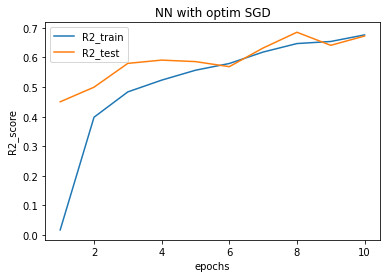

In [23]:
visual_metrics(r2_train_list_SGD, r2_test_list_SGD, 'SGD')

#### Оптимизатор Adam

In [24]:
model = FeedForward(8, 400)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
r2_train_list_Adam, r2_test_list_Adam = train_eval_model(model, optimizer, 10)

Epoch 1: r2_train = 0.15409058332443237, r2_val = 0.5270931720733643
Epoch 2: r2_train = 0.5050986409187317, r2_val = 0.5877459049224854
Epoch 3: r2_train = 0.5735474228858948, r2_val = 0.6477718353271484
Epoch 4: r2_train = 0.6305599212646484, r2_val = 0.6806620955467224
Epoch 5: r2_train = 0.6615914106369019, r2_val = 0.6877421140670776
Epoch 6: r2_train = 0.6728895902633667, r2_val = 0.6998723745346069
Epoch 7: r2_train = 0.680575966835022, r2_val = 0.6644916534423828
Epoch 8: r2_train = 0.6977256536483765, r2_val = 0.6782888174057007
Epoch 9: r2_train = 0.7032991051673889, r2_val = 0.715631365776062
Epoch 10: r2_train = 0.7048736810684204, r2_val = 0.713447093963623


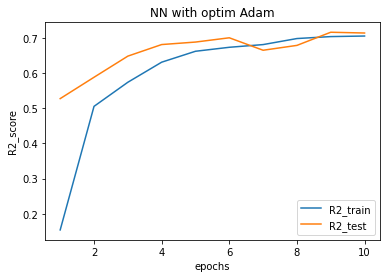

In [25]:
visual_metrics(r2_train_list_Adam, r2_test_list_Adam, 'Adam')

#### Оптимизатор  RMSprop

In [26]:
model = FeedForward(8, 400)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
r2_train_list_RMS, r2_test_list_RMS = train_eval_model(model, optimizer, 10)

Epoch 1: r2_train = 0.1524564027786255, r2_val = 0.5567177534103394
Epoch 2: r2_train = 0.5357444286346436, r2_val = 0.6443506479263306
Epoch 3: r2_train = 0.5972220301628113, r2_val = 0.6325391530990601
Epoch 4: r2_train = 0.6334823369979858, r2_val = 0.6547067761421204
Epoch 5: r2_train = 0.6592715382575989, r2_val = 0.7008247971534729
Epoch 6: r2_train = 0.6675530672073364, r2_val = 0.6969237923622131
Epoch 7: r2_train = 0.6800909042358398, r2_val = 0.7270370721817017
Epoch 8: r2_train = 0.6922587752342224, r2_val = 0.7145576477050781
Epoch 9: r2_train = 0.6983839273452759, r2_val = 0.710883378982544
Epoch 10: r2_train = 0.6961566209793091, r2_val = 0.6857627630233765


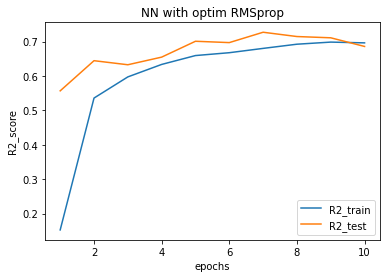

In [27]:
visual_metrics(r2_train_list_RMS, r2_test_list_RMS, 'RMSprop')

## 4. Сводная таблица метрик моделей и вывод <a id='section_4'></a>

In [28]:
# сводная таблица метрик моделей
metrics_result = pd.DataFrame([{'r2_train': r2_train_list_SGD[-1].item(), 'r2_test': r2_test_list_SGD[-1].item()},
                               {'r2_train': r2_train_list_Adam[-1].item(), 'r2_test': r2_test_list_Adam[-1].item()},
                               {'r2_train': r2_train_list_RMS[-1].item(), 'r2_test': r2_test_list_RMS[-1].item()}],
                              index =['SGD', 'Adam', 'RMSprop'], 
                              columns =['r2_train', 'r2_test'])

metrics_result.sort_values(by='r2_test', ascending=False)

,r2_train,r2_test
Adam,0.704874,0.713447
RMSprop,0.696157,0.685763
SGD,0.676350,0.672605


Adam**Вывод:** лучшие показатели модели по метрике достигается с применением оптимизатора RMSprop. 